In [1]:
import scanpy
import numpy as np
import scprep
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('..')
from utils import *

In [3]:
cmap = {'Ins_1': 'salmon', 'Vehicle-STZ': 'darkseagreen', 'β1': 'lightblue', 'β2': 'cornflowerblue', 'β-mSTZ': 'midnightblue','Ctrl': 'darkmagenta', 'Vehicle-STZ': 'darkseagreen'}

In [5]:
stz = scanpy.read_h5ad('data/stz_beta_ins1_ins2.h5ad')

In [28]:
# set 6 cells annotated as beta-mSTZ in Ctrl as beta-2 to prioritize differences between "mature" and "immature" differences
stz.obs.loc[(stz.obs.groups_named_fine == 'β-mSTZ') & (stz.obs.treatment == 'Ctrl'), 'groups_named_fine'] = 'β2'

In [30]:
stz_ctrl = stz[stz.obs['groups_named_broad_cond'] == 'beta_Ctrl']
stz_treatment = stz[stz.obs['treatment'] == 'Vehicle-STZ']
proliferation = np.load('results/gcs_4tp_2.npy')

In [31]:
colors = list(sns.color_palette('Set1', n_colors=4)) + \
list(sns.color_palette('Paired', n_colors=3)) + ['lightgray'] + \
list(sns.color_palette('Set2', n_colors=7).as_hex())

at_cmap = dict(zip(adata_beta.obs['AT_committment'].cat.categories, colors))
at_order = ['WT AT 1', 'WT AT 2', 'WT AT 3', 'WT AT 4', 'WT AT 5', 'WT AT 6', 'WT AT 7',
            'HFD AT 1', 'HFD AT 2', 'HFD AT 3', 'HFD AT 4', 'OB/OB AT 1', 'OB/OB AT 2', 'OB/OB AT 3', 'Uncommitted']
at_cmap = dict(zip(at_order, [at_cmap[key] for key in at_order]))

## Visualize trajectories and COI

In [53]:
pca_trajectory = np.load(f'results/stz_4_tp_at_assignment_run1_growth/backward_trajectories.npy')
last_timepoint_mask = stz_treatment.obs['TrajectoryNet_timepoints'] == 3
at_committment_mask = stz_treatment[last_timepoint_mask].obs['AT_committment'] == f'OB/OB AT 2'
pca_trajectory = pca_trajectory[:, at_committment_mask, :]
nearest_cells_to_cluster_3 = get_cells_of_origin(pca_trajectory, stz.obsm['data_magic_pc_norm'])

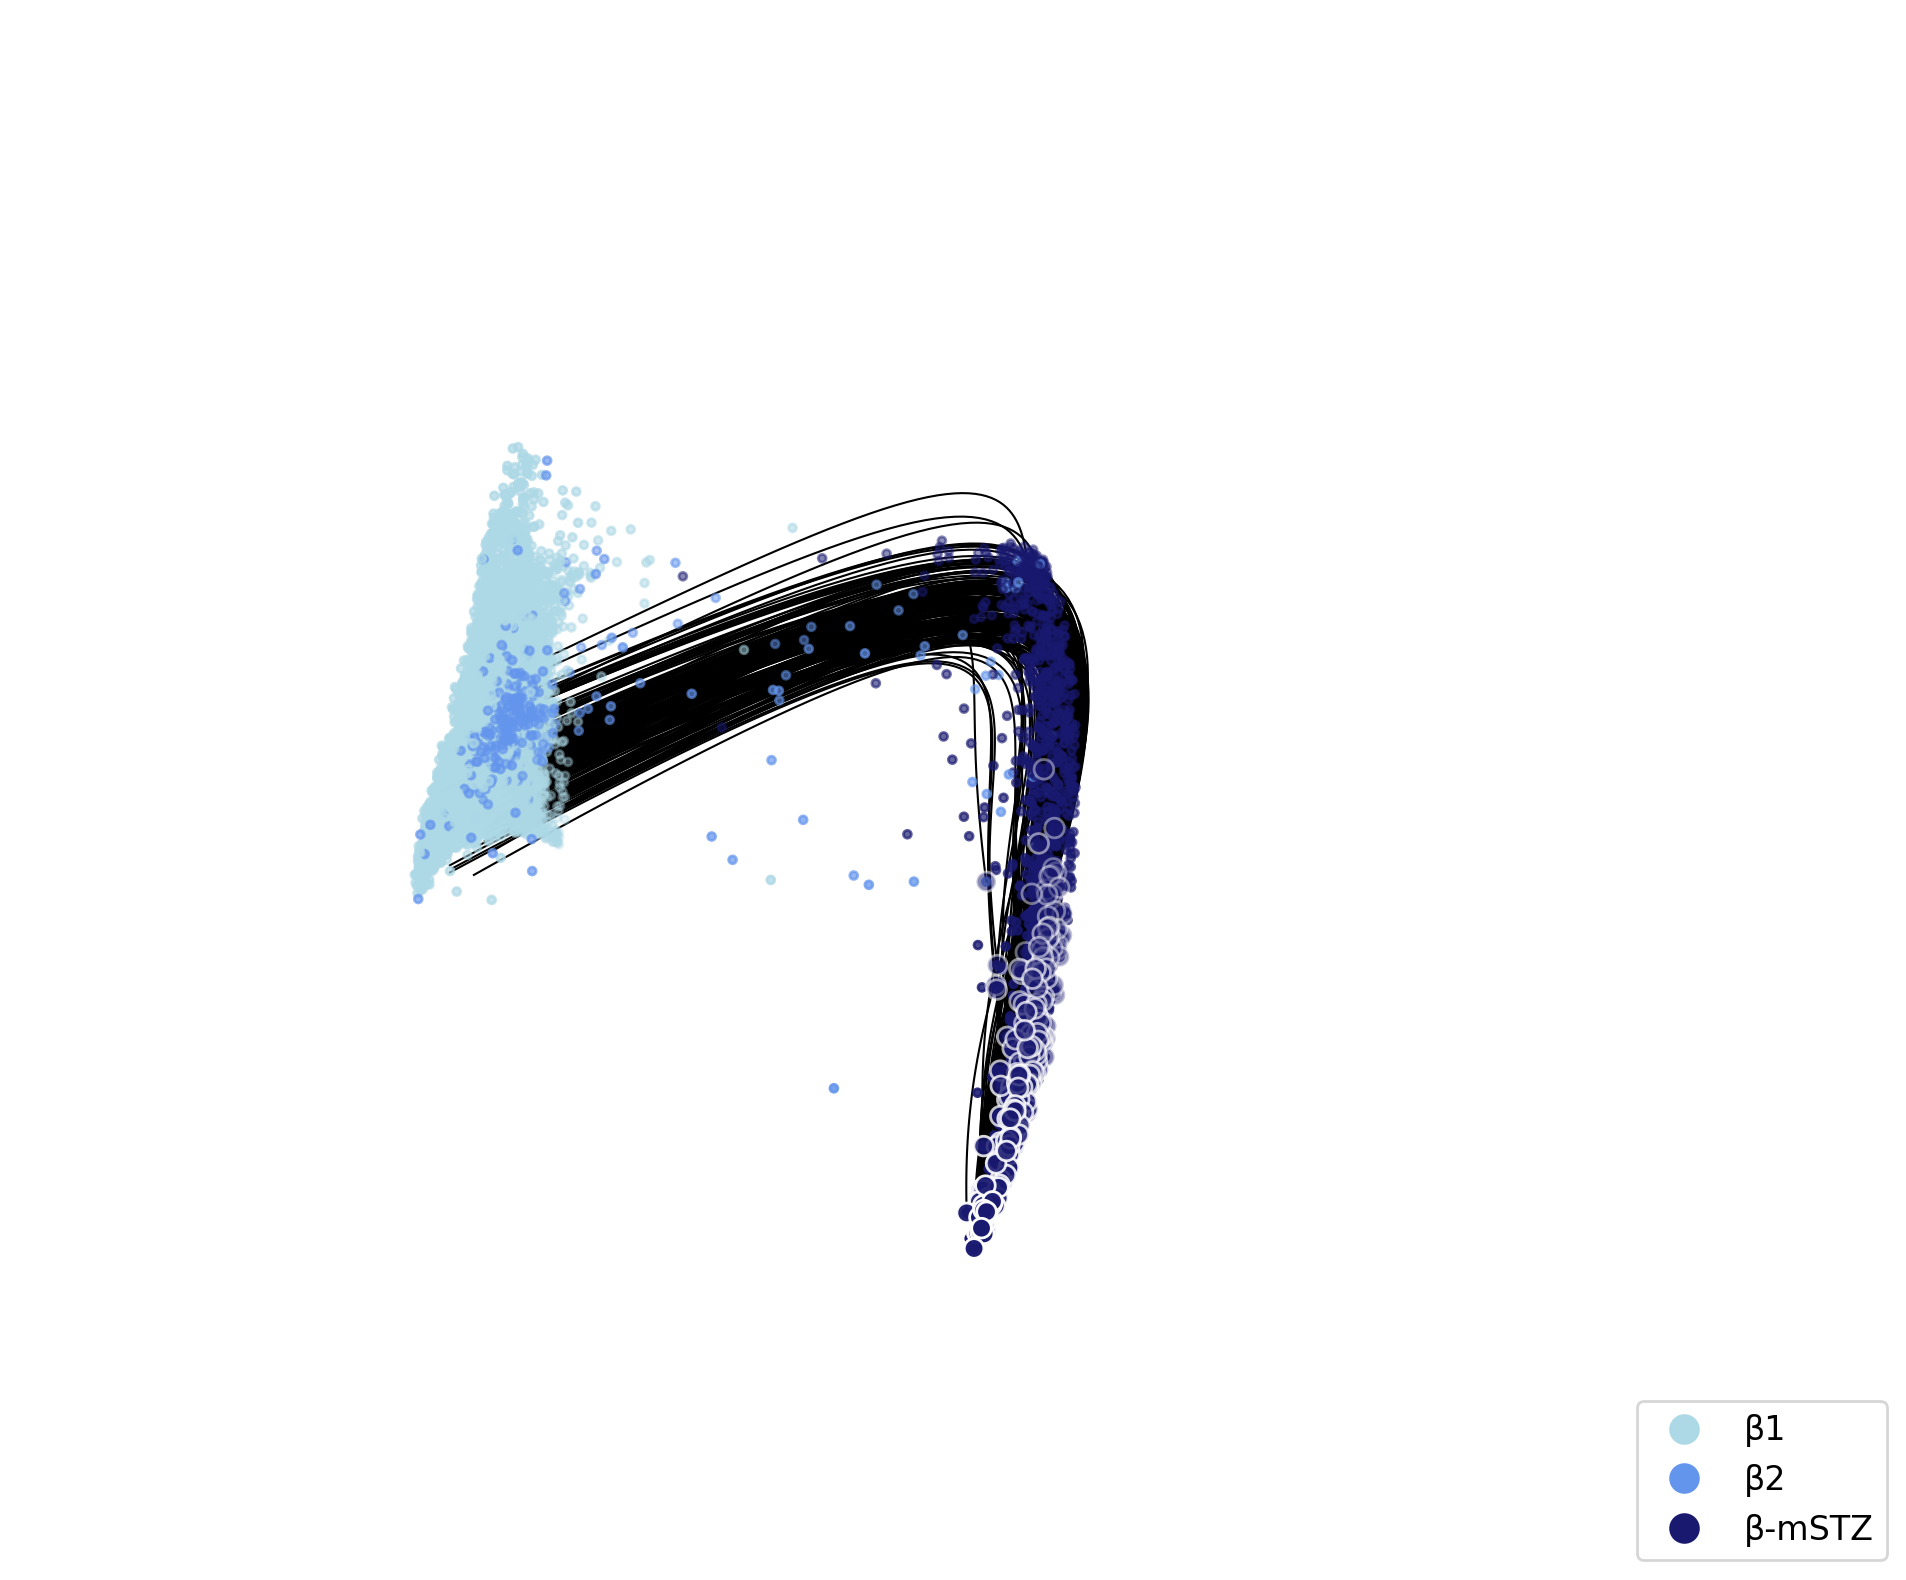

In [54]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
numlines = 200

for i in range(numlines):
    ax.plot(pca_trajectory[:, i, 0],
            pca_trajectory[:, i, 1],
            pca_trajectory[:, i, 2], linewidth=0.75, c='k')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], s=8, c=stz.obs['groups_named_fine'], figsize=(6,6), cmap=cmap, ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60)
scprep.plot.scatter3d(pca_trajectory[0, :200, :],
                      color='midnightblue', edgecolor='white', ax=ax, s=50)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/stz_trajectories.png', dpi=200)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


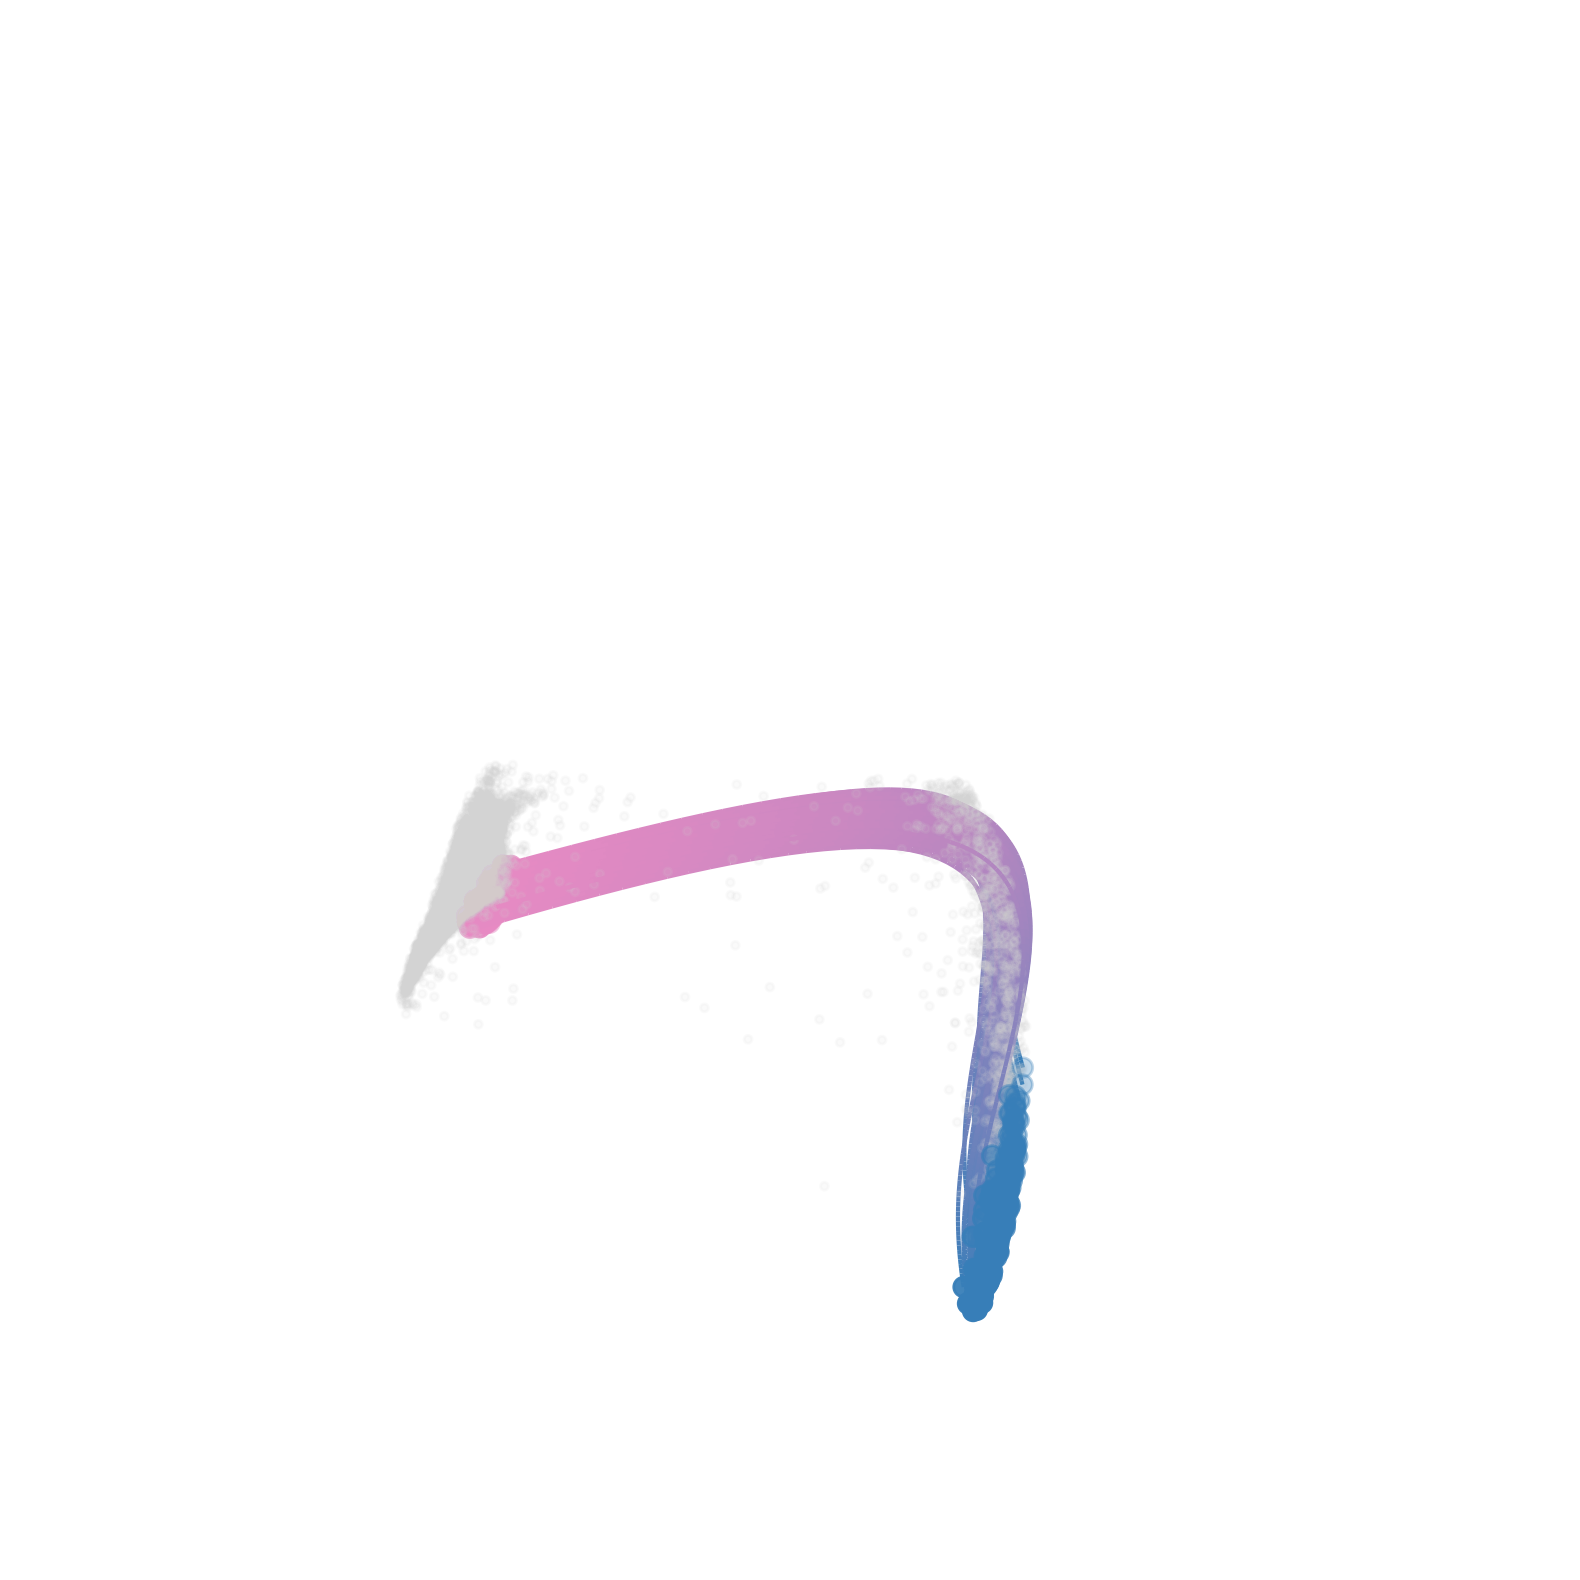

In [55]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
numlines = 200
mask = stz.obs.iloc[nearest_cells_to_cluster_3]['groups_named_fine'] == 'β2'
for i in np.where(mask)[0]:
    x = pca_trajectory[:, i, 0]
    y = pca_trajectory[:, i, 1]
    z= pca_trajectory[:, i, 2]
    t = np.linspace(0,1,100)
    
    # generate a list of (x,y,z) points
    points = np.array([x,y,z]).transpose().reshape(-1,1,3)
    
    # set up a list of segments
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    
    # make the collection of segments
    lc = Line3DCollection(segs, cmap=cm)
    lc.set_array(t) # color the segments by our parameter
    
    ax.add_collection3d(lc)

scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], s=8, c='lightgray', figsize=(6,6),ticks=[], ax=ax, legend_loc=(1.05,0), alpha=0.1)
scprep.plot.scatter3d(pca_trajectory[0, mask, :], c=at_cmap['OB/OB AT 2'], ax=ax, s=50)
scprep.plot.scatter3d(pca_trajectory[-1, mask, :], c=at_cmap['WT AT 4'], ax=ax, s=50)

plt.tight_layout()
ax.axis('off')
fig.savefig('figures/stz_trajectories_from_Ins2.png', dpi=200)

In [56]:
# confirm tracing back only to ctrl
pd.Series(np.array(stz.obs.treatment)[nearest_cells_to_cluster_3]).value_counts()

Ctrl    303
Name: count, dtype: int64

# Repeat for TrajectoryNet run 2

In [58]:
pca_trajectory = np.load(f'results/stz_4_tp_at_assignment_run2_growth/backward_trajectories.npy')
last_timepoint_mask = stz_treatment.obs['TrajectoryNet_timepoints'] == 3
at_committment_mask = stz_treatment[last_timepoint_mask].obs['AT_committment'] == f'OB/OB AT 2'
pca_trajectory = pca_trajectory[:, at_committment_mask, :]
nearest_cells_to_cluster_3 = get_cells_of_origin(pca_trajectory, stz.obsm['data_magic_pc_norm'])

In [59]:
# confirm tracing back only to ctrl
pd.Series(np.array(stz.obs.treatment)[nearest_cells_to_cluster_3]).value_counts()

Ctrl    303
Name: count, dtype: int64

In [60]:
expected = (pd.Series(stz_ctrl.obs.groups_named_fine).value_counts() / stz_ctrl.n_obs) * len(nearest_cells_to_cluster_3)
observed = pd.Series(np.array(stz.obs.groups_named_fine)[nearest_cells_to_cluster_3]).value_counts()
df2 = observed/expected

## Combine two runs for AT enrichment

In [70]:
df = pd.concat((df1, df2))

/tmp/ipykernel_2266804/1011598856.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index,


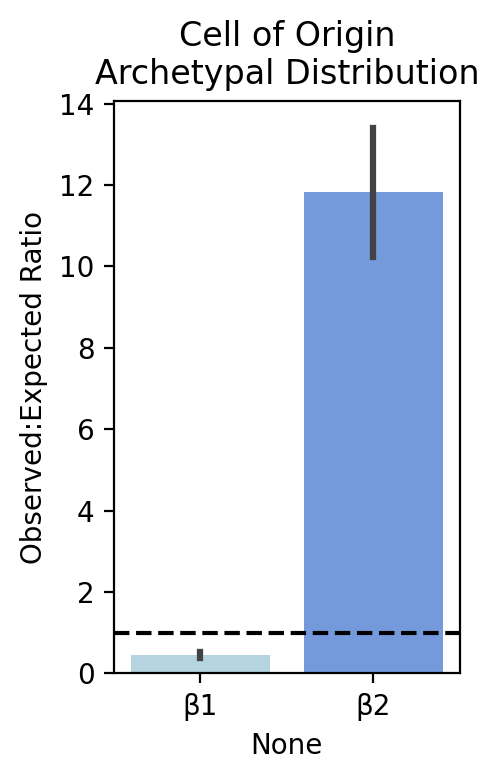

In [74]:
matplotlib.rc_file_defaults()
f = plt.figure(dpi=200, figsize=(2.5,4))
plt.title('Cell of Origin\nArchetypal Distribution', color='black')

sns.barplot(x=df.index,
            y=df.values,
            palette=[cmap['β1'], cmap['β2']])

plt.axhline(1, c='black', linestyle='dashed')
plt.ylabel('Observed:Expected Ratio')
plt.tight_layout()
fig.savefig(f'figures/OB_OB_2_cell_of_origin_archetypal_distributions.png', dpi=200)